In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                 transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
                                 ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                 transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
                                 ]))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
data_variance = np.var(training_data.data / 255.0)

In [ ]:
class VectorQuantizer(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, commitment_cost):
    super(VectorQuantizer, self).__init__()

    self._embedding_dim = embedding_dim
    self._num_embeddings = num_embeddings

    self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
    self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
    self._commitment_cost = commitment_cost

  def forward(self, inputs):
    # latent input (B, C, H, W) -> (B, H, W, C)
    inputs = inputs.permute(0, 2, 3, 1).contiguous()
    inputs_shape = inputs.shape

    # latent input (B, H, W, C) -> (B*H*W, C=D)
    flatten = inputs.view(-1, self._embedding_dim)

    # distance (no square root)
    distance = (torch.sum(flatten**2, dim=1, keepdim=True) + torch.sum(self._embedding.weight**2, dim=1)
                - 2 * torch.matmul(flatten, self._embedding.weight.T))

    # get index
    encoding_indices = torch.argmin(distance, dim=1).unsqueeze(1)
    encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)

    # (B*H*W, K) one-hot encoding
    encodings.scatter_(1, encoding_indices, 1)

    # (B*H*W, D) -> (B, C, H, W)
    quantized = torch.matmul(encodings, self._embedding.weight).view(inputs_shape)

    # Define Loss
    codebook_loss = F.mse_loss(quantized.detach(), inputs) # optimize inputs close to codebook
    commitment_loss = F.mse_loss(quantized, inputs.detach()) # optimize codebook close to inputs
    loss = codebook_loss + self._commitment_cost * commitment_loss

    # Loss is directly delivered from quantized to inputs
    quantized = inputs + (quantized - inputs).detach()

    # latent output (B*H*W, C = D) -> (B, C, H, W)
    quantized = quantized.permute(0, 3, 1, 2).contiguous()

    # get perplexity e^h (h is entrophy)
    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10))) # avoiding log0?

    return loss, quantized, encodings, perplexity

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
    super(ResBlock, self).__init__()
    self.block = nn.Sequential(
        nn.ReLU(True),
        nn.Conv2d(in_channels=in_channels, out_channels=num_residual_hiddens, kernel_size=3, stride=1, padding=1),
        nn.ReLU(True),
        nn.Conv2d(in_channels=num_residual_hiddens, out_channels=num_hiddens, kernel_size=1, stride=1, bias=False),
    )

  def forward(self, x):
    x = x + self.block(x)
    return x

class ResidualStack(nn.Module):
  def __init__(self, in_channels, num_hiddens, num_residual_hiddens, num_residual_layers):
    super(ResidualStack, self).__init__()
    self.num_residual_layers = num_residual_layers
    self.stack = nn.ModuleList([ResBlock(in_channels, num_hiddens, num_residual_hiddens)]*num_residual_layers)

  def forward(self, x):
    for layer in self.stack:
      x = layer(x)
    x = F.relu(x)
    return x

In [ ]:
class Encoder(nn.Module):
  def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
    super(Encoder, self).__init__()
    self.encoder_stack = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=num_hiddens//2, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=num_hiddens//2, out_channels= num_hiddens, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=num_hiddens, out_channels=num_hiddens, kernel_size=3, stride=1, padding=1),
        ResidualStack(num_hiddens, num_hiddens, num_residual_hiddens, num_residual_layers)
    )

  def forward(self, x):
    return self.encoder_stack(x)

In [ ]:
class Decoder(nn.Module):
  def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
    super(Decoder, self).__init__()
    self.decoder_stack = nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=num_hiddens, kernel_size=3 ,stride=1, padding=1),
        ResidualStack(num_hiddens, num_hiddens, num_residual_hiddens, num_residual_layers),
        nn.ConvTranspose2d(in_channels=num_hiddens, out_channels=num_hiddens//2, kernel_size=4, stride=2, padding=1),
        nn.ConvTranspose2d(in_channels=num_hiddens//2, out_channels=3, kernel_size=4, stride=2, padding=1),
    )

  def forward(self, x):
    return self.decoder_stack(x)

In [ ]:
# Hyperparameter
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25
learning_rate = 1e-3

log_interval = 100

In [ ]:
training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True, pin_memory=True)

In [ ]:
class Model(nn.Module):
  def __init__(self, num_hiddens, num_residual_hiddens, num_residual_layers, num_embeddings, embedding_dim, commitment_cost):
    super(Model, self).__init__()

    self.encoder_layer = Encoder(3, num_hiddens, num_residual_layers, num_residual_hiddens)
    self.decoder_layer = Decoder(embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens)
    self.vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
    self.pre_vq = nn.Conv2d(in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1, stride=1)

  def forward(self, x):
    z = self.encoder_layer(x)
    z = self.pre_vq(z)
    loss, quantized, encodings, perplexity = self.vq_vae(z)
    x_rec = self.decoder_layer(quantized)

    return x_rec, loss, perplexity

In [ ]:
model = Model(num_hiddens, num_residual_hiddens, num_residual_layers, num_embeddings, embedding_dim, commitment_cost).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_rec_loss = []
train_perplexity = []

In [ ]:
model.train()

Model(
  (encoder_layer): Encoder(
    (encoder_stack): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ResidualStack(
        (stack): ModuleList(
          (0-1): 2 x ResBlock(
            (block): Sequential(
              (0): ReLU(inplace=True)
              (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (2): ReLU(inplace=True)
              (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
          )
        )
      )
    )
  )
  (decoder_layer): Decoder(
    (decoder_stack): Sequential(
      (0): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResidualStack(
        (stack): ModuleList(
          (0-1): 2 x ResBlock(
            

In [ ]:
def train():

  for i in range(num_training_updates):
    (x, _) = next(iter(training_loader))
    x = x.to(device)
    optimizer.zero_grad()

    x_rec, embedding_loss, perplexity = model(x)
    rec_loss = F.mse_loss(x_rec, x)/data_variance
    loss = embedding_loss + rec_loss
    loss.backward()

    optimizer.step()

    train_rec_loss.append(rec_loss.item())
    train_perplexity.append(perplexity.item())

    if i % log_interval == 0:
      print('%d iterations' % (i+1))
      print('recon_error: %.3f' % np.mean(train_rec_loss[-100:]))
      print('perplexity: %.3f' % np.mean(train_perplexity[-100:]))

In [ ]:
train()

1 iterations
recon_error: 1.130
perplexity: 1.749
101 iterations
recon_error: 0.627
perplexity: 2.285
201 iterations
recon_error: 0.377
perplexity: 3.995
301 iterations
recon_error: 0.291
perplexity: 7.172
401 iterations
recon_error: 0.252
perplexity: 8.779
501 iterations
recon_error: 0.221
perplexity: 11.793
601 iterations
recon_error: 0.195
perplexity: 16.206
701 iterations
recon_error: 0.184
perplexity: 20.288
801 iterations
recon_error: 0.172
perplexity: 25.751
901 iterations
recon_error: 0.165
perplexity: 30.364
1001 iterations
recon_error: 0.153
perplexity: 34.845
1101 iterations
recon_error: 0.143
perplexity: 38.496
1201 iterations
recon_error: 0.136
perplexity: 42.816
1301 iterations
recon_error: 0.129
perplexity: 47.574
1401 iterations
recon_error: 0.121
perplexity: 53.039
1501 iterations
recon_error: 0.116
perplexity: 57.227
1601 iterations
recon_error: 0.111
perplexity: 61.540
1701 iterations
recon_error: 0.107
perplexity: 65.331
1801 iterations
recon_error: 0.104
perplexity

In [ ]:
def plot_metrics(train_rec_loss, train_perplexity):
  train_res_recon_error_smooth = savgol_filter(train_rec_loss, 201, 7)
  train_res_perplexity_smooth = savgol_filter(train_perplexity, 201, 7)
  f = plt.figure(figsize=(16,4))
  ax = f.add_subplot(1,2,1)
  ax.plot(train_rec_loss)
  ax.set_yscale('log')
  ax.set_title('Reconstruction Error')
  ax.set_xlabel('iteration')

  ax = f.add_subplot(1,2,2)
  ax.plot(train_perplexity)
  ax.set_title('Average codebook usage (perplexity).')
  ax.set_xlabel('iteration')

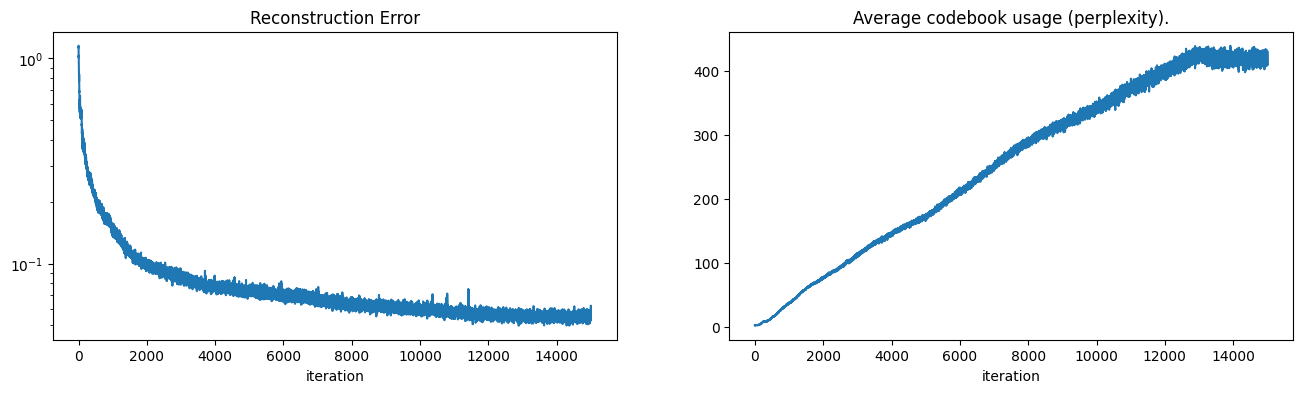

In [ ]:
plot_metrics(train_rec_loss, train_perplexity)

In [ ]:
model.eval()

Model(
  (encoder_layer): Encoder(
    (encoder_stack): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ResidualStack(
        (stack): ModuleList(
          (0-1): 2 x ResBlock(
            (block): Sequential(
              (0): ReLU(inplace=True)
              (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (2): ReLU(inplace=True)
              (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
          )
        )
      )
    )
  )
  (decoder_layer): Decoder(
    (decoder_stack): Sequential(
      (0): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResidualStack(
        (stack): ModuleList(
          (0-1): 2 x ResBlock(
            

In [ ]:
(x, _) = next(iter(validation_loader))
x = x.to(device)
x_tmp = model.pre_vq(model.encoder_layer(x))
_, quantized, _, _ = model.vq_vae(x_tmp)
valid_rec = model.decoder_layer(quantized)

In [ ]:
def display(x):
  x = make_grid(x.cpu().detach()+0.5)
  x = x.numpy()
  fig = plt.imshow(np.transpose(x, (1,2,0)), interpolation='nearest')
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)

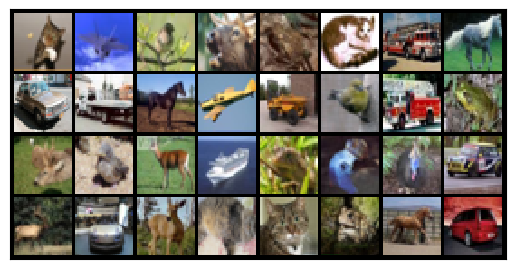

In [ ]:
display(x)

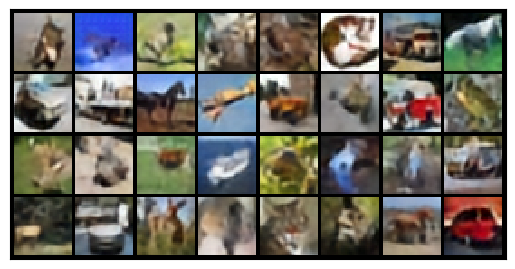

In [ ]:
display(valid_rec)